In [1]:
import json
import os

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import pycountry as pc

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import superrouters
from lhledge import loadGeographicData

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
CYCLE = 10019
DATE = 20220501
DOWNSAMPLING = 1

In [4]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [5]:
def ecdf2(df, field, field_aux):
    df = df.sort_values(field)
    y = np.cumsum(df.groupby(field)["router_id"].count().values)
    y = y / max(y)
    x = df.drop_duplicates(field)[field].values
    return x, y

In [6]:
def geneate_input_filename():

    filename = cfg["paths"]["ark"]["consolidated-long-haul-explorations"].format(DATE, CYCLE, DOWNSAMPLING)

    return filename

In [7]:
def alpha3_to_alpha2(cc3):
    try:
        country = pc.countries.get(alpha_3=cc3)
        return country.alpha_2
    except:
        return "??"


In [8]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

# Load data

## Geographic data

In [9]:
cepii = loadGeographicData.load_inter_country_distances("data/external/cepii/dist_cepii.csv", 
                                     "data/processed/min-cc-dist/min_cc_dist.csv")
cepii.head()

,cc_src,cc_dst,dist
0,AW,AW,5.225315
1,AW,AF,13257.810000
2,AW,AO,9516.913000
3,AW,AI,983.268200
4,AW,AL,9091.742000


## LHLs

In [10]:
lhl = pd.read_csv(geneate_input_filename(), compression="bz2")
lhl["mpls_tunnel"] = lhl["mpls_tunnel"].values.astype(bool)
lhl.head()

,near_side_addr,far_side_addr,mpls_tunnel,near_side_rdns,far_side_rdns,near_side_rtt,far_side_rtt,near_side_timestamp,far_side_timestamp,near_node_id,far_node_id,near_node_asn,far_node_asn,near_side_cc,far_side_cc,near_side_lat,near_side_lon,far_side_lat,far_side_lon,diff_rtt
0,1.1.10.5,220.177.251.10,False,1.1.10.5,10.251.177.220.broad.nc.jx.dynamic.163data.com.cn,167.529,245.570,1.651394e+09,1.651394e+09,1336104,26620343,4134,4134,CN,CN,34.77320,113.72200,39.91691,116.39706,78.041
1,1.120.111.254,1.157.139.55,False,cpe-1-120-111-254.nb13.nsw.asp.telstra.net,cpe-1-157-139-55.nb13.nsw.asp.telstra.net,34.812,43.901,1.651404e+09,1.651404e+09,3865246,0,1221,0,AU,??,-33.86010,151.21010,0.00000,0.00000,9.089
2,1.120.15.254,58.171.171.124,False,gw.vb11.vic.asp.telstra.net,58.171.171.124,167.812,179.487,1.651383e+09,1.651383e+09,1185539,24979552,1221,1221,GW,AU,12.00000,-15.00000,-37.71930,144.66770,11.675
3,1.123.255.254,110.147.147.136,False,cpe-1-223-255-254.bpw7-r-032.way.wa.bigpond.ne...,cpe-110-147-147-136.vb13.vic.asp.telstra.net,160.099,169.319,1.651381e+09,1.651381e+09,5604360,0,1221,0,AU,??,-33.86785,151.20732,0.00000,0.00000,9.220
4,1.156.255.254,124.180.87.177,False,1.156.255.254,cpe-124-180-87-177.qb09.qld.asp.telstra.net,309.108,345.721,1.651395e+09,1.651395e+09,24637264,0,1221,0,AU,??,-27.46790,153.03250,0.00000,0.00000,36.613


In [11]:
_geoloc_hops = lhlFilters.find_min_rtt(lhl)
filtered_geoloc_hops = lhlFilters.filter_with_cepii(cepii, _geoloc_hops)

In [12]:
filtered_geoloc_hops.shape

(51994, 13)

# Super routers

In [13]:
all_superrouters = superrouters.find_super_routers(filtered_geoloc_hops.loc[filtered_geoloc_hops["diff_rtt"] > 40])
all_superrouters.head()

,router_id,router_cc,asn,cc_cnt,cc_list
8302,26780,SE,1299,40,"[LK, CN, TH, HK, MA, IN, TR, PR, BR, NP, GD, V..."
10523,344817,US,3257,25,"[BG, GB, HK, BR, BE, PL, AU, ES, DE, NL, DK, C..."
10536,849875,US,9002,25,"[BG, GB, RU, IN, SN, PL, DE, NL, ZM, SK, CZ, U..."
190,3313,US,3257,25,"[BG, GB, HK, BR, BE, PL, ES, DE, NL, DK, LU, S..."
10546,1754342,US,3257,24,"[BG, GB, HK, BE, PL, AU, ES, NO, DE, NL, DK, S..."


In [14]:
MM = []

asns = all_superrouters.loc[all_superrouters["cc_cnt"] >= 5] \
    .groupby("asn")["cc_cnt"] \
    .count() \
    .reset_index() \
    .sort_values("cc_cnt", ascending=False) \
    .head(8)["asn"] \
    .values

asns = asns[::-1]

M = []

for asn in asns:
    count = all_superrouters.loc[(all_superrouters["cc_cnt"] >= 5) \
                              & (all_superrouters["asn"] == asn)] \
    .groupby("cc_cnt")["asn"] \
    .count() \
    .reset_index()

    l = []
    for i in range(5, 25):
        c = count.loc[count["cc_cnt"] == i]["asn"]
        if len(c) > 0 :
            c = c.values[0]
        else:
            c = 0
        l.append(c)

    M.append(l)


MM.append(M)

#

cc_list = all_superrouters.loc[all_superrouters["cc_cnt"] >= 5] \
    .groupby("router_cc")["router_id"] \
    .count() \
    .reset_index() \
    .sort_values("router_id", ascending=False)["router_cc"] \
    .head(8) \
    .values


cc_list = cc_list[::-1]
M = []

for cc in cc_list:
    count = all_superrouters.loc[(all_superrouters["router_cc"] == cc)
                                  & (all_superrouters["cc_cnt"] >= 5)] \
        .groupby("cc_cnt")["router_cc"] \
        .count() \
        .reset_index()

    l = []
    for i in range(5, 25):
        c = count.loc[count["cc_cnt"] == i]["router_cc"]
        if len(c) > 0 :
            c = c.values[0]
        else:
            c = 0
        l.append(c)

    M.append(l)

MM.append(M)

/tmp/ipykernel_163855/1295337181.py:36: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{M[i][j]:d}",


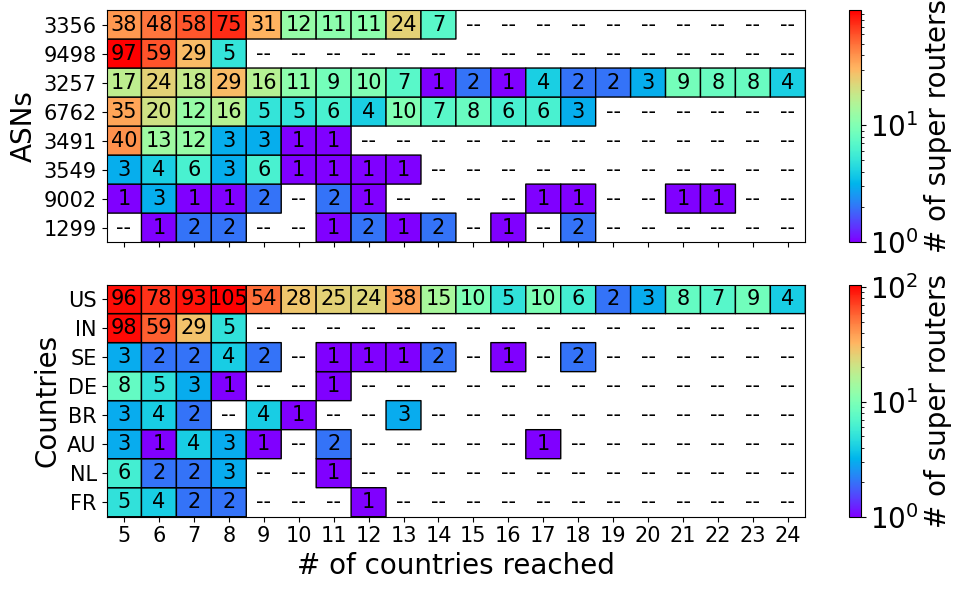

In [15]:

fig, ax_list = plt.subplots(2, figsize=(10, 6), sharex=True)

for loc in range(2):

    ax = ax_list[loc]
    M = MM[loc]

    M = np.ma.masked_where(M == 0, M)
    M = np.ma.masked_where(M == 0, M)

    heatmap = ax.pcolor(
        np.arange(M.shape[1] + 1),
        np.arange(M.shape[0] + 1),
        M,
        norm=colors.LogNorm(
            vmin=M[M>0].min(),
            vmax=M.max()
        ),
        cmap='rainbow',
        edgecolors='black',
        linewidths=1,
    )


    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_ylabel('# of super routers', fontsize=20)

    ax.set_xticks(np.arange(0.5, M.shape[1] + 0.5))
    ax.set_xticklabels(range(5, 25))
    ax.set_yticks(np.arange(0.5, M.shape[0] + 0.5))

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.annotate(
                f"{M[i][j]:d}",
                (j + 0.5, i + 0.5),
                # fontsize=10,
                fontsize=15,
                color="black",
                va="center",
                ha="center",
                rotation=0
            )




    if loc == 1:
        ax.set_xlabel('# of countries reached', fontsize=20)
        ax.set_ylabel('Countries', fontsize=20)
        ax.set_yticklabels(cc_list)
    else:
        ax.set_ylabel('ASNs', fontsize=20)
        ax.set_yticklabels(np.array(asns).astype(int))


    ax.tick_params(labelsize=15)
# ax.set_xlim(1990, 2030)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/superrouters/countries_ases_leaders_in_use_of_superrouters.pdf")

In [16]:
all_superrouters

,router_id,router_cc,asn,cc_cnt,cc_list
8302,26780,SE,1299,40,"[LK, CN, TH, HK, MA, IN, TR, PR, BR, NP, GD, V..."
10523,344817,US,3257,25,"[BG, GB, HK, BR, BE, PL, AU, ES, DE, NL, DK, C..."
10536,849875,US,9002,25,"[BG, GB, RU, IN, SN, PL, DE, NL, ZM, SK, CZ, U..."
190,3313,US,3257,25,"[BG, GB, HK, BR, BE, PL, ES, DE, NL, DK, LU, S..."
10546,1754342,US,3257,24,"[BG, GB, HK, BE, PL, AU, ES, NO, DE, NL, DK, S..."
...,...,...,...,...,...
9551,14880,US,20473,1,[SE]
9552,16465,SE,1299,1,[US]
9553,11040,US,1299,1,[SE]
9554,879021,US,3549,1,[SE]


In [17]:
all_superrouters[(all_superrouters["router_cc"] == "US")
                 & (all_superrouters["cc_cnt"] >= 5)].shape[0] / \
all_superrouters.loc[(all_superrouters["cc_cnt"] >= 5)].shape[0]

0.5811567164179104

In [18]:
cc_touching = []

for i in range(0, 75, 3):

    c = all_superrouters.loc[all_superrouters["cc_cnt"] >= i]["asn"].size
    print(i, c)
    cc_touching.append(c)

0 21261
3 2270
6 786
9 303
12 170
15 78
18 49
21 36
24 8
27 1
30 1
33 1
36 1
39 1
42 0
45 0
48 0
51 0
54 0
57 0
60 0
63 0
66 0
69 0
72 0


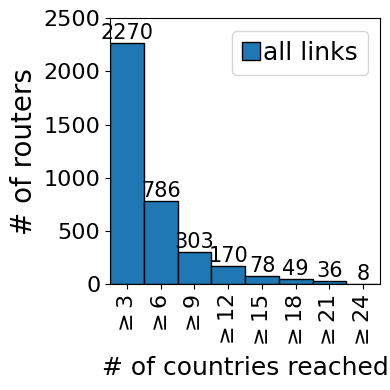

In [19]:
fig, ax = plt.subplots(1, figsize=(4, 4))

ax.bar(
    np.arange(len(cc_touching[1:9])),
    cc_touching[1:9],
    width=1,
    edgecolor="k",
    label=f"all links"
)

for x, y in zip(np.arange(len(cc_touching[1:9])), cc_touching[1:9]):
    ax.annotate(
        f"{y:d}",
        (x, y),
        fontsize=15,
        color="black",
        va="bottom",
        ha="center",
        rotation=0
    )

xl = []
for x in range(0, 75, 3)[1:9]:
    xl.append(f"$\geq${x:d}")

ax.set_ylabel('# of routers', fontsize=20)
ax.set_xlabel('# of countries reached', fontsize=18)

ax.set_xticks(np.arange(len(cc_touching[1:9])))
ax.set_xticklabels(xl, rotation=90)

ax.legend(loc='upper right', ncol=1, frameon=True, fontsize=18,
          handletextpad=0.1, columnspacing=0.1, handlelength=0.75)

ax.tick_params(labelsize=16)
ax.set_xlim(-0.5, 7.5)
ax.set_ylim(0, 2500)
fig.subplots_adjust(hspace=0)
fig.tight_layout()
# fig.savefig("figures/superrouters/superrouters_details.pdf")

In [20]:
all_superrouters.loc[all_superrouters["cc_cnt"] >= 9] \
                .drop_duplicates("asn")["asn"].size

11